<font size="+3" color=Blue><b> <center><u>Image Classification on any custom dataset</u></center></b></font>

<a id="3"></a>
<font color="blue" size=+2.5><b>2.1 Installation of Libraries </b></font>

## !pip install fastai

<a id="4"></a>
<font color="blue" size=+2.5><b>2.2 Library Import</b></font>


!pip install fastai==1.0.61

In [1]:
#importing libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn import preprocessing

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from fastai.imports import *

<a id="5"></a>
<font color="blue" size=+2.5><b>3.1 Setting up path for training data</b></font>

**Point to be Noted: Number of elements in a list of path is same as number of classes you have**

In [2]:
x  = 'content'
path = Path(x)
path.ls()


[WindowsPath('content/seg_test'), WindowsPath('content/seg_train')]

<a id="6"></a>
<font color="blue" size=+2.5><b>3.2 Data Loading For training</b></font>
<br/>

**Things to be remember:**
* Decide validation percentage ( 0.2 => 20% )
* Provide path for training data
* [Decide augmentations criteria (optional)](https://www.kaggle.com/init27/introduction-to-image-augmentation-using-fastai/)
* Decide image size (which is 224 in my case)
* Test data can also be added but it's optional

In [3]:
np.random.seed(40)
data = ImageDataBunch.from_folder(path, train = 'seg_train',test='seg_test', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4,).normalize(imagenet_stats)


C:\Users\MSI\anaconda3\envs\OB2\lib\site-packages\fastai\vision\transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


In [19]:
np.random.seed(40)
data2 = ImageDataBunch.from_folder(path, train = 'seg_test', valid_pct=0,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4,).normalize(imagenet_stats)

<a id="7"></a>
<font color="blue" size=+2.5><b>3.3 Data Explorations</b></font>
<br/>

*Our image dataset is stored as .jpg files in 2 different folders, with each folder bearing the name of model of the images contained in the folder. We use the ImageDataBunch.from_folder() function to load the images and assign labels the images based on the name of the folder they’re read from.*

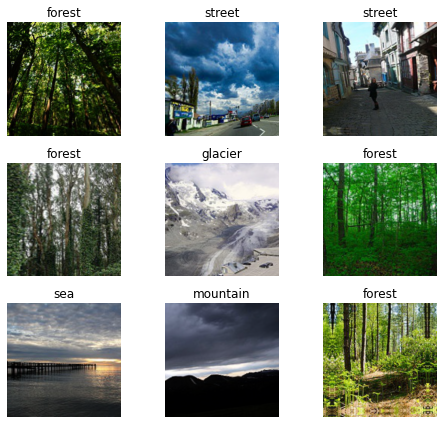

In [4]:
data.show_batch(rows=3, figsize=(7,6),recompute_scale_factor=True)

<a id="8"></a>
<font color="blue" size=+2.5><b>3.4 Print Classes present in the data</b></font>
<br/>

* data.c — How many classes are there in our dataset?
* len(data.train_ds) — What is the size of our training dataset?
* len(data.valid_ds) — What is the size of our validation dataset?

In [5]:
data

ImageDataBunch;

Train: LabelList (11228 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
buildings,buildings,buildings,buildings,buildings
Path: content;

Valid: LabelList (2806 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mountain,buildings,buildings,buildings,buildings
Path: content;

Test: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: content

In [6]:
print(data.classes)
len(data.classes)
data.c

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


6

In [7]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070'

<a id="9"></a>
<font color="blue" size=+2.5><b>4.1 Create Model</b></font>
<br/>
* We now use a pre-trained ResNet18 Convolutional Neural Net model, and use transfer learning to learn weights of only the last layer of the network.
* Why Transfer learning? Because with transfer learning, you begin with an existing (trained) neural network used for image recognition — and then tweak it a bit (or more) here and there to train a model for your particular use case. And why do we do that? Training a reasonable neural network would mean needing approximately 300,000 image samples, and to achieve really good performance, we’re going to need at least a million images.
* In our case, we have approximately 2500 images in our training set — you have one guess to decide if that would have been enough if were to train a neural net from scratch.
* We use the create_cnn() function for loading a pre-trained ResNet18 network, that was trained on around a million images from the ImageNet database.

In [8]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], model_dir = Path('Model'),path = Path("."))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\MSI/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

C:\Users\MSI\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# <a id="10"></a>
<font color="blue" size=+2.5><b>4.2 Finding LR</b></font>
<br/>

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


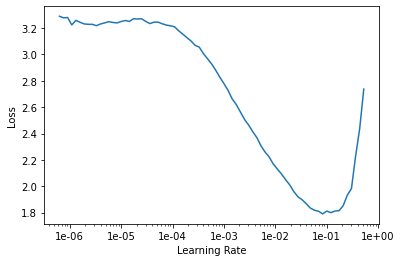

In [9]:
learn.lr_find()
learn.recorder.plot(suggestions=True)

<a id="11"></a>
<font color="blue" size=+2.5><b>4.3 Train Model</b></font>
<br/>

In [10]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(40,slice(lr1,lr2))

<a id="12"></a>
<font color="blue" size=+2.5><b>4.4 Hyper Parameter Tuning</b></font>


In [11]:
learn.unfreeze()
learn.fit_one_cycle(20,slice(1e-4,1e-3))


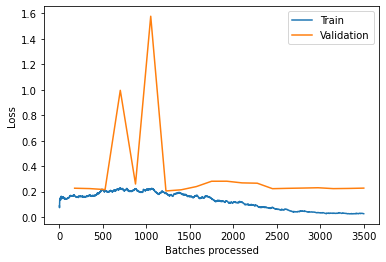

In [12]:
learn.recorder.plot_losses()

# <a id="13"></a>
<font color="blue" size=+2.5><b>5.1 Interpret the results</b></font>

Model performance can be validated in different ways. One of the popular methods is using the confusion matrix. Diagonal values of the matrix indicate correct predictions for each class, whereas other cell values indicate a number of wrong predictions.

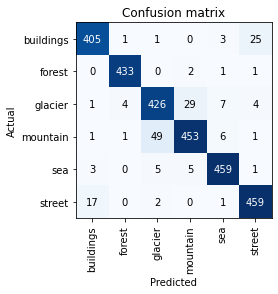

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

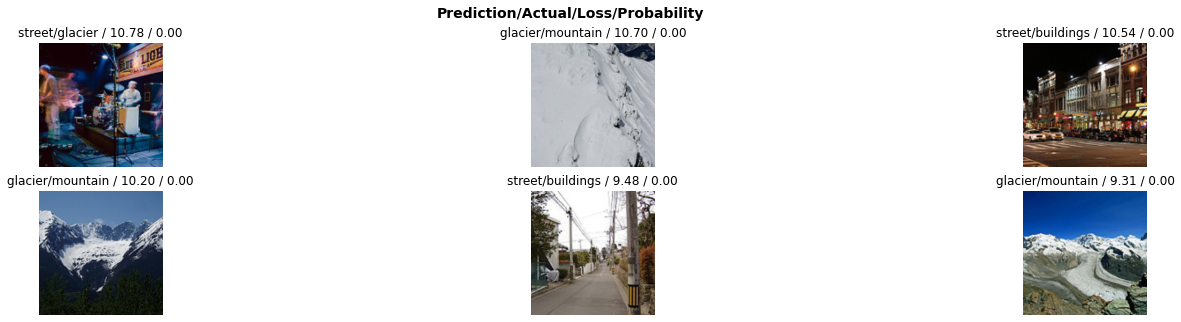

In [14]:
interp.plot_top_losses(6,figsize = (25,5))

<a id="14"></a>
<font color="blue" size=+2.5><b>5.2 Prediction Using Trained Model</b></font>

In [21]:
print(data2.classes)
len(data2.classes)
data2.c
data2

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


ImageDataBunch;

Train: LabelList (17034 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
buildings,buildings,buildings,buildings,buildings
Path: content;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: content;

Test: None

In [22]:
interp = ClassificationInterpretation.from_learner(learn, data2)


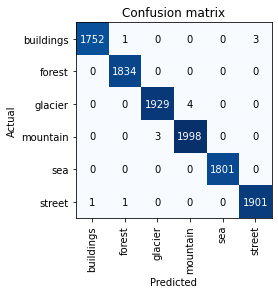

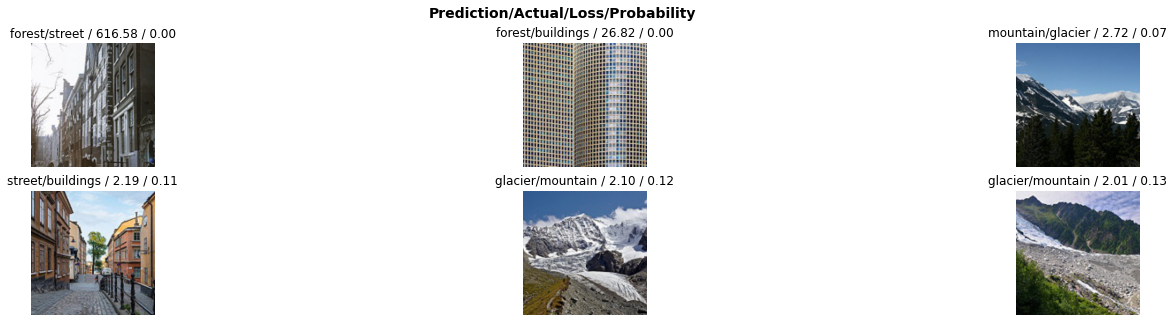

In [23]:
interp.plot_confusion_matrix()
interp.plot_top_losses(6,figsize = (25,5))

<a id="15"></a>
<font color="blue" size=+2.5><b>5.3 Save and Load Model</b></font>

street
mountain
street
mountain
mountain
forest
sea
glacier
sea
street
sea
street
mountain
buildings
buildings
glacier
forest
forest
mountain
sea


C:\Users\MSI\anaconda3\envs\OB2\lib\site-packages\fastai\vision\image.py:434: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if ax is None: fig,ax = plt.subplots(figsize=figsize)


street
street
street
street
glacier
buildings
forest


KeyboardInterrupt: 

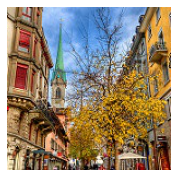

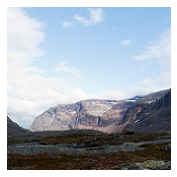

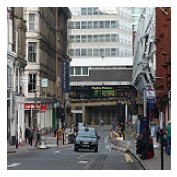

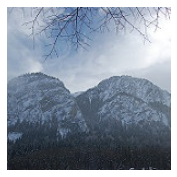

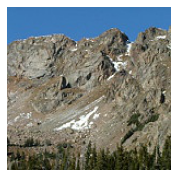

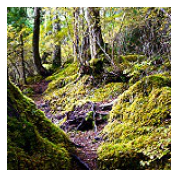

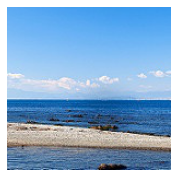

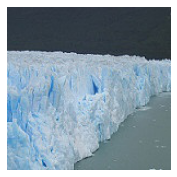

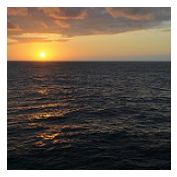

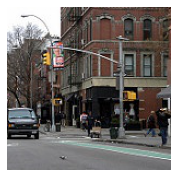

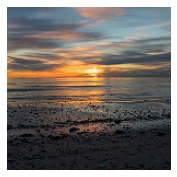

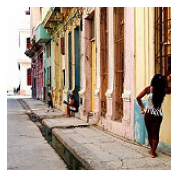

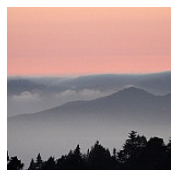

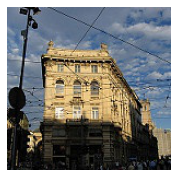

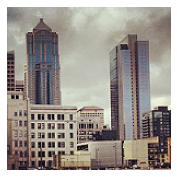

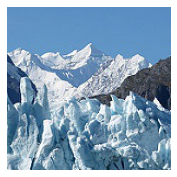

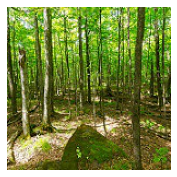

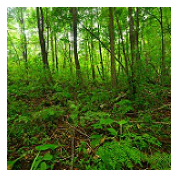

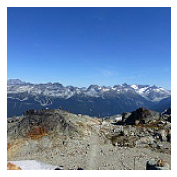

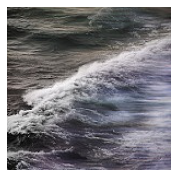

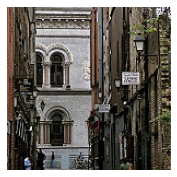

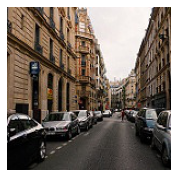

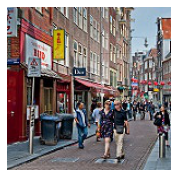

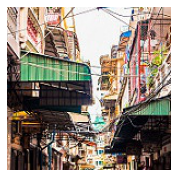

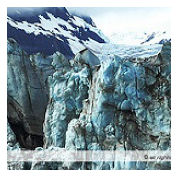

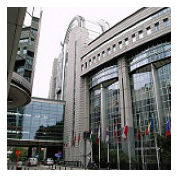

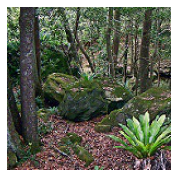

<Figure size 216x216 with 0 Axes>

In [72]:
from skimage import io
folder_dir = "content/predict"
for images in os.listdir(folder_dir):
    img = open_image('content/predict/'+images)
    show = open_image('content/predict/'+images)
    show_image(show) 
    for k in range(1):
        print(learn.predict(img)[0])
    time.sleep(0.1)
    

In [74]:
learn.export(file = Path("Model/working/export.pkl"))
learn.model_dir = "/Model/working"
learn.save("stage-1",return_path=True)

WindowsPath('/Model/working/stage-1.pth')

In [76]:
learn2 = load_learner("Model/working/",'export.pkl')

street
mountain
street
mountain
mountain
forest
sea
glacier
sea
street
sea
street
mountain
buildings
buildings
glacier
forest
forest


KeyboardInterrupt: 

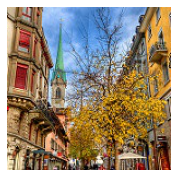

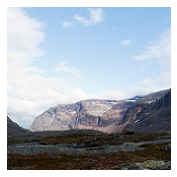

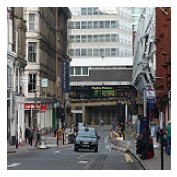

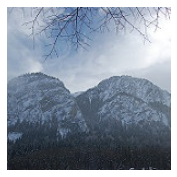

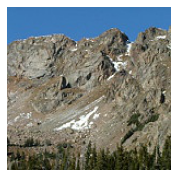

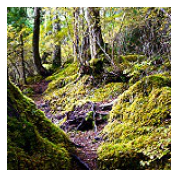

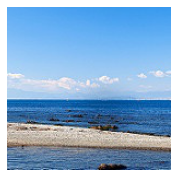

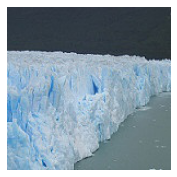

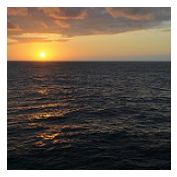

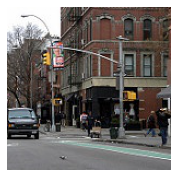

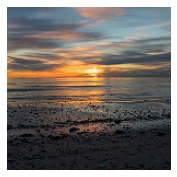

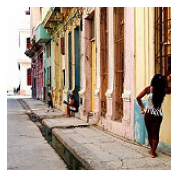

Error in callback <function flush_figures at 0x0000016E9A56A280> (for post_execute):


KeyboardInterrupt: 

In [77]:
folder_dir = "content/predict"
for images in os.listdir(folder_dir):
    img = open_image('content/predict/'+images)
    show = open_image('content/predict/'+images)
    show_image(show) 
    for k in range(1):
        print(learn2.predict(img)[0])
    time.sleep(0.1)